# Interpretability techniques for single samples from RVL-CDIP subset - LayoutLMVV3

## GITHUB

In [1]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 594 (delta 104), reused 112 (delta 50), pack-reused 414 (from 1)
Receiving objects: 100% (594/594), 14.61 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [92]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 355 bytes | 355.00 KiB/s, done.
From https://github.com/adamserag1/Interpretability-for-VRDU-models
 * branch            HEAD       -> FETCH_HEAD
Updating 7f5c549..e85b841
Fast-forward
 Classification_Explain/lime.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [2]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [ ]:
!pip install -r requirements.txt

## Libraries

In [98]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForSequenceClassification, AutoProcessor
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()

Reloading module: vrdu_utils.module_types
Reloading module: vrdu_utils.utils
Reloading module: vrdu_utils.encoders
Reloading module: vrdu_utils
Reloading module: Classification_Explain.lime
Reloading module: Classification_Explain


## Data + Model Setup

In [93]:
from google.colab import drive
drive.mount("/content/drive")
!cp -r /content/drive/MyDrive/THESIS/rvl_cdip_financial_subset /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
rvl = load_from_disk('/content/rvl_cdip_financial_subset')
dataset_split = rvl.train_test_split(test_size=0.2, seed=42)
val = dataset_split["test"]
val_ds = DocSampleDataset(val)

# Extract samples 'agree' (LLMV3 + BROS classify correct) and 'CLASH' (LLMV3 classify wrong, BROS classify correct)

AGREE = val_ds[108] # (contents, idx)
CLASH = val_ds[100] # (contents, idx)

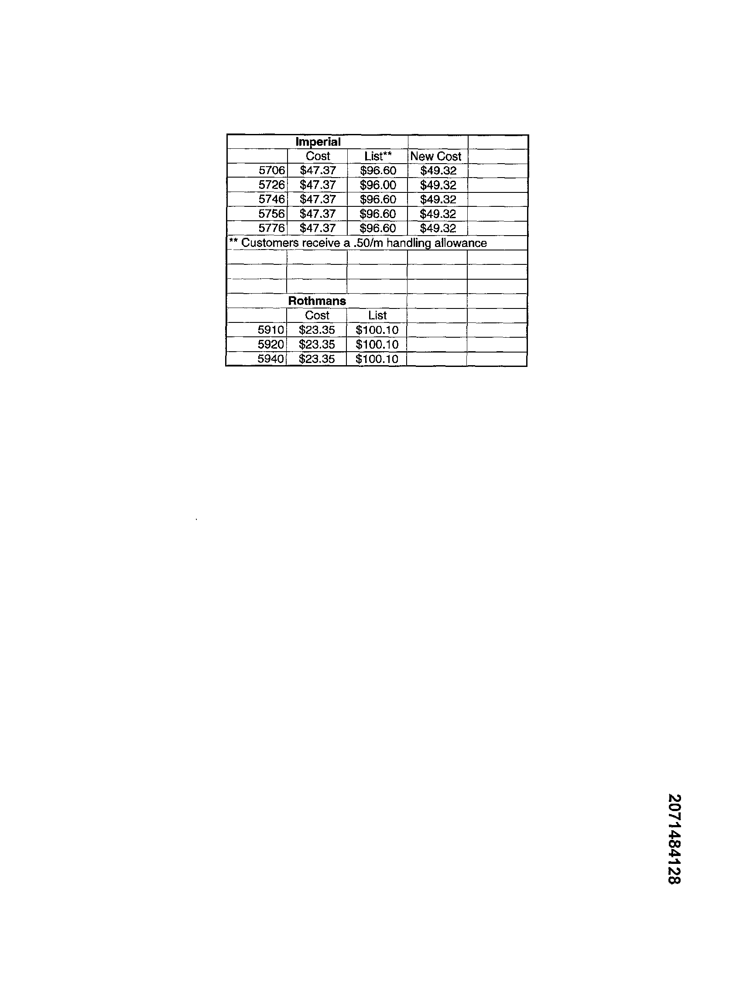

In [95]:
AGREE[0].image

In [96]:
# CLASH[0].image

In [97]:
LLMV3 = LayoutLMv3ForSequenceClassification.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned",
                                                            num_labels=5,
                                                            id2label={0: "form", 1: "invoice", 2: "budget", 3: "file folder", 4: "questionnaire"},
                                                            label2id={"form": 0, "invoice": 1, "budget": 2, "file folder": 3, "questionnaire": 4})
LLMV3_proc = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc)
LLMV3.to(device)

LayoutLMv3ForSequenceClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Enco

## Interpreting the 'Agree' sample

### Text Modality

In [53]:
text_explainer = LimeTextExplainer(
    LLMV3,
    LLMV3_encode,
    mask_token = LLMV3_proc.tokenizer.mask_token,
    batch_size = 2,
    kernel_width_factor = 0.75,
    labels = [2]
)

In [59]:
text_vals = text_explainer.explain(AGREE[0], align_boxes=False, num_samples=2000, num_features=10)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


In [55]:
probs = text_explainer._predict([AGREE[0]])
print("Softmax probabilities:", probs)

Softmax probabilities: [[2.7396638e-05 1.7901391e-05 9.9991941e-01 2.2284592e-05 1.3028820e-05]]


In [60]:
print("Explanation score (R²):", text_vals.score)
for word, weight in text_vals.as_list(label=2):
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.05564233899846838
allowance=1 -> -0.0178452501
Cost=1     -> +0.0175736166
handling=1 -> +0.0133166015
$49.82=1   -> +0.0130671143
$23.35=1   -> +0.0126921633
$23.35,=1  -> +0.0124359067
$23.95=1   -> +0.0110979073
receive=1  -> -0.0108406213
$49.32=1   -> +0.0099445259
$49.82=1   -> +0.0092084917


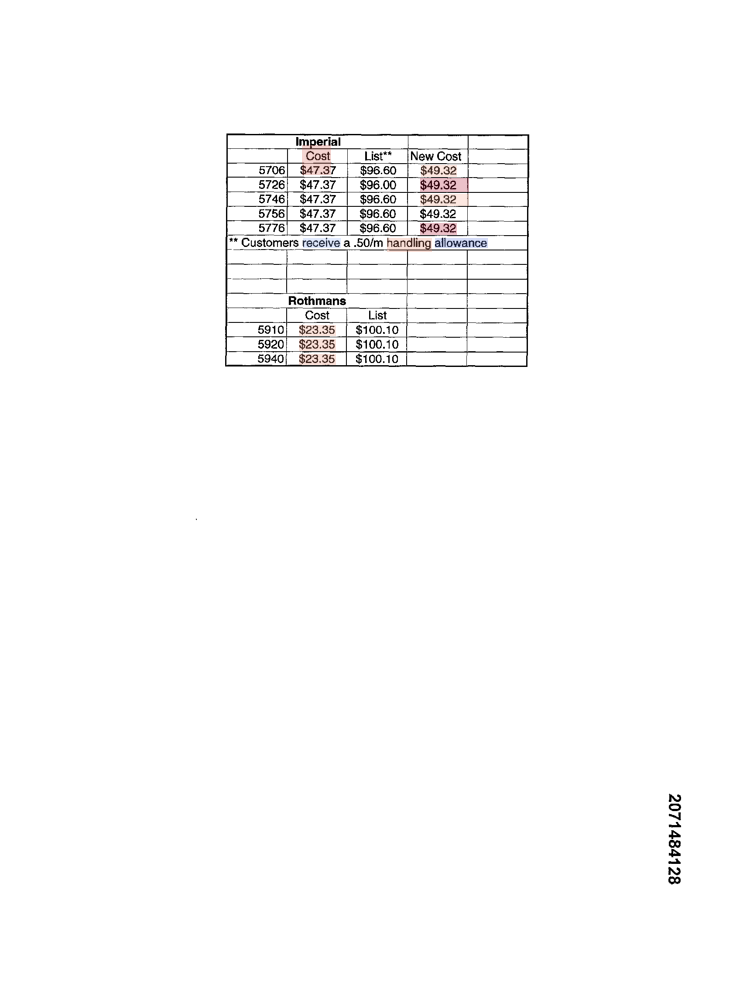

In [62]:
from vrdu_utils.utils import draw_lime_token_heatmap
import re
weights = {}
for token, w in text_vals.as_list(label=2):
    clean = re.sub(r"=\d+$", "", token)     # drop '=number' suffix
    weights[clean] = weights.get(clean, 0.0) + w

draw_lime_token_heatmap(image = AGREE[0].image, words = AGREE[0].words, boxes = AGREE[0].bboxes, weights = weights, alpha = 0.25)

## Layout

In [65]:
layout_explainer = LimeLayoutExplainer(
    LLMV3,
    LLMV3_encode,
    batch_size = 4,
    mask_token = LLMV3_proc.tokenizer.mask_token,
    labels = [2]
)

layout_vals = layout_explainer.explain(AGREE[0], num_samples=2000, num_features=10)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 500/500 [00:35<00:00, 13.93it/s]


In [72]:
print("Explanation score (R²):", layout_vals.score)
for word, weight in layout_vals.as_list(label=2):
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.1312834739900418
allowance=1 -> -0.0682816759
Cost=1     -> +0.0507003871
receive=1  -> -0.0460824712
$49.82=1   -> +0.0439029035
handling=1 -> +0.0425330237
$23.35,=1  -> +0.0406580743
$47.37=1   -> +0.0281408231
$23.35=1   -> +0.0269313145
$23.95=1   -> +0.0248565680
$49.92,=1  -> +0.0191558167


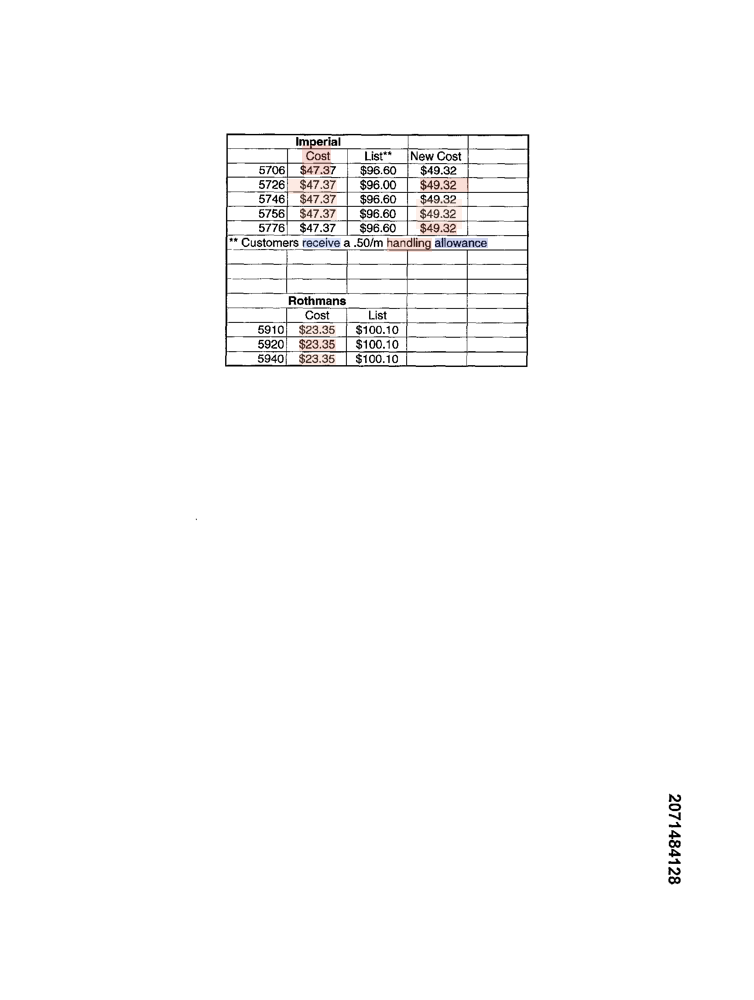

In [69]:
from vrdu_utils.utils import draw_lime_token_heatmap
import re
weights = {}
for token, w in layout_vals.as_list(label=2):
    clean = re.sub(r"=\d+$", "", token)     # drop '=number' suffix
    weights[clean] = weights.get(clean, 0.0) + w

draw_lime_token_heatmap(image = AGREE[0].image, words = AGREE[0].words, boxes = AGREE[0].bboxes, weights = weights, alpha = 0.25)

### Vision

In [99]:
vision_explainer = LimeVisionExplainer(
    LLMV3,
    LLMV3_encode,
    batch_size=4,
    label = 2
)

vision_vals = vision_explainer.explain(AGREE[0], num_samples=2000, num_features=10)

  0%|          | 0/2000 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
print("Explanation score (R²):", vision_vals.score)

Explanation score (R²): 0.4999955177896892


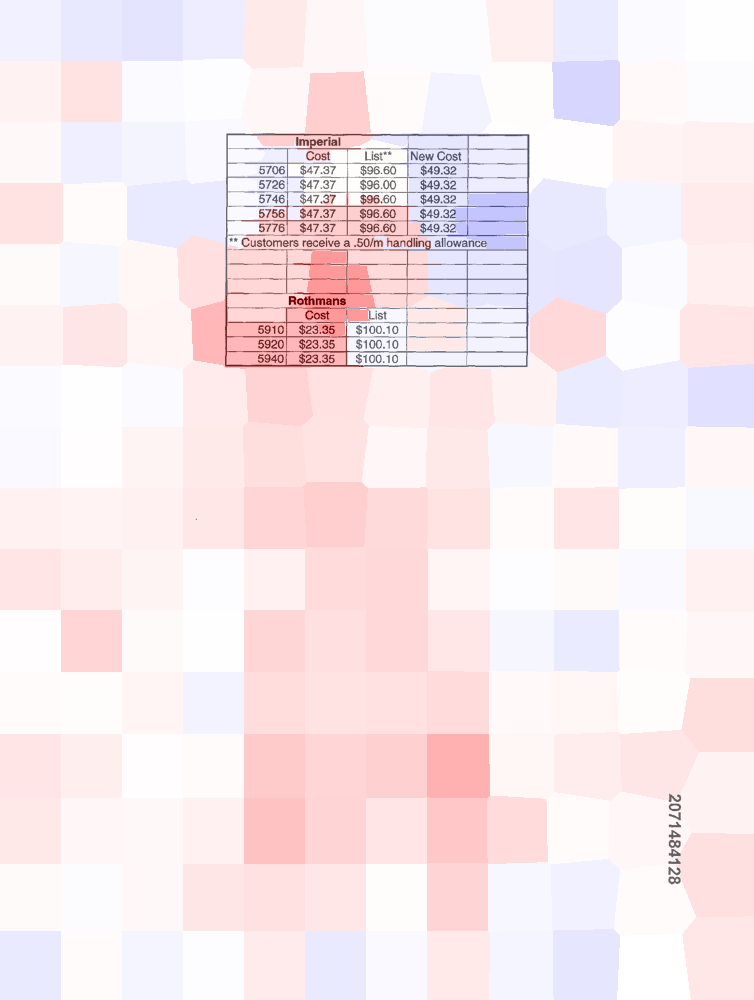

In [104]:
segment_weights = dict(vision_vals.local_exp[2])

# Create weight map
segments = vision_vals.segments
weight_map = np.zeros_like(segments, dtype=float)
for seg_id, weight in segment_weights.items():
    weight_map[segments == seg_id] = weight

# Define overlay function
def lime_weight_to_overlay(image_np, weight_map, alpha=0.4):
    max_weight = np.max(np.abs(weight_map))
    if max_weight == 0:
        max_weight = 1
    normalized_weights = weight_map / max_weight
    r = np.where(normalized_weights > 0, 255,
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    g = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    b = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255, 255))
    color_map = np.stack([r, g, b], axis=-1).astype(np.uint8)
    overlay = ((1 - alpha) * image_np + alpha * color_map).clip(0, 255).astype(np.uint8)
    return overlay

# Apply overlay
img_np = vision_vals.image
heat_np = lime_weight_to_overlay(img_np, weight_map, alpha=0.4)

# Display
Image.fromarray(heat_np)

In [81]:
from PIL import Image

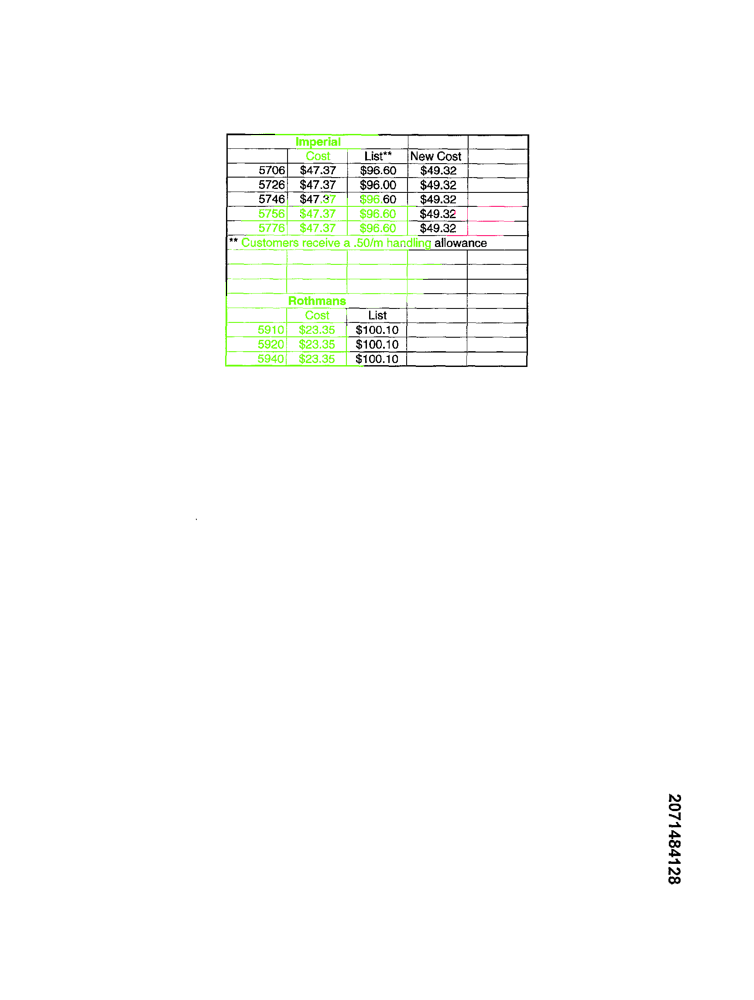

In [102]:
img_np, mask = vision_vals.get_image_and_mask(
    label = 2,
    positive_only=False,   # include negative weights too
    num_features=30,
    hide_rest=False
)

heat_np = lime_mask_to_overlay(img_np, mask, alpha=0.40)
Image.fromarray(heat_np)

In [74]:
print("Explanation score (R²):", vision_vals.score)
for word, weight in vision_vals:
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.4999955177896892


TypeError: 'ImageExplanation' object is not iterable